In [1]:
from io import open
import pickle
import sys
sys.path.insert(0,'./zipped_files_from_www')
sys.path.insert(0,'./Boyu')
from posterior import *
from sklearn.metrics import average_precision_score,precision_recall_fscore_support,confusion_matrix, roc_curve, auc, classification_report, average_precision_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from helper import *
#from random_slice import *
cats = ["Business & Industrial","Home & Garden","Travel","Arts & Entertainment","Sports","Food & Drink","Pets & Animals","Health","Shopping","Finance","Adult","Beauty & Fitness","News","Books & Literature","Online Communities","Law & Government","Sensitive Subjects","Science","Hobbies & Leisure","Games","Jobs & Education","Autos & Vehicles","Computers & Electronics","People & Society","Reference","Internet & Telecom","Real Estate"]

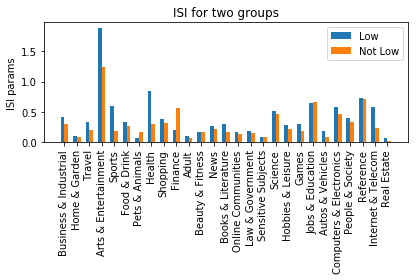

In [2]:
ls_compound, nls_compound = load_pickle("Boyu/compound_vectors_self_esteem.pkl")
psi_compound, npsi_compound = load_pickle('Boyu/compound_vectors_psi.pkl')
ls_lambda = [(elem[0],elem[1][27:]) for elem in ls_compound]
nls_lambda = [(elem[0],elem[1][27:]) for elem in nls_compound]
#print(len(ls_compound[0][1]))

ls_joint = [(elem[0],elem[1][:27]*elem[1][27:]) for elem in ls_compound]
nls_joint = [(elem[0],elem[1][:27]*elem[1][27:]) for elem in nls_compound]
plot_features(ls_lambda,nls_lambda)
#plot_features(ls_joint,nls_joint)
#plot_features(low_list_norm, notlow_list_norm)
#plt.show()

In [ ]:
train_lambda, train_label, test_lambda, test_label = random_split(low_list,notlow_list)

In [ ]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)


simMatrix = np.load('zipped_files_from_www/sim_mat.npy')

print(simMatrix.shape)
print(is_pos_def(simMatrix))
print('==================')
simMatrix2 = np.loadtxt("zipped_files_from_www/similarity_matrix.csv", dtype='float32', delimiter=',')
print(is_pos_def(simMatrix2))
cov_W = simMatrix2
cov_W_inv = inv(cov_W)

# cov_W = (1- simMatrix) + np.identity(len(cats))
mu_W = np.zeros(len(cats))
print(mu_W.shape)
print(cov_W.shape)
print('Shape: similarity matrix',simMatrix.shape)
print('Shape: covariance matrix',cov_W.shape)
print(is_pos_def(cov_W))
#print(cov_W)
# cov_W = np.eye(27)

In [ ]:
bmodel = Bayes_model(train_lambda,train_label ,cov_W,mu_W)
samples_w, samples_sigma = bmodel.metropolis_hastings()

In [ ]:
def print_trace():
    precisions = []
    recalls = []
    f1s = []

    total_miss = []
    class1_precisions = []
    class0_precisions = []

    class1_f1s = []
    class0_f1s = []

    class1_recalls = []
    class0_recalls = []

    class1_miss = []
    class0_miss = []

    #print(sum(test_lambda,axis=1))

    w = np.mean(samples_w, axis=0)
    sig = np.mean(samples_sigma)
    p = sigmoid(np.dot(test_lambda, w) + np.random.normal())
    # y_hat = [np.random.binomial(1, i) for i in p]
    print(p)
    y_hat = []
    for i in p:
        if i <= 0.5:
            y_hat.append(1)
        else:
            y_hat.append(0)
    print('===================')
    for i in range(len(y_hat)):
        print('predicted:', y_hat[i], '\t\t true:',test_label[i])

    # print y_hat
    cr = classification_report(test_label, y_hat)
    cm = confusion_matrix(test_label, y_hat)
    print(cr)
    print(cm)
    num_class0_miss = cm[0][1] 
    num_class1_miss = cm[1][0]
    l= cr.split('avg / total')[-1].strip().split()
    #print(l)
    #avg_prec, avg_recal,avg_f1,_ = cr.split('avg / total')[-1].strip().split()

    clf_rep = precision_recall_fscore_support(test_label, y_hat)
    out_dict = {
        "precision" :clf_rep[0].round(2)
        ,"recall" : clf_rep[1].round(2)
        ,"f1-score" : clf_rep[2].round(2)
        ,"support" : clf_rep[3]
    }
    print(out_dict)
    class0_recalls.append(out_dict['recall'][0])
    class0_f1s.append(out_dict['f1-score'][0])
    class0_precisions.append(out_dict['precision'][0])
    class0_miss.append(num_class0_miss)

    class1_recalls.append(out_dict['recall'][1])
    class1_f1s.append(out_dict['f1-score'][1])
    class1_precisions.append(out_dict['precision'][1])
    class1_miss.append(num_class1_miss)
    total_miss.append(num_class0_miss+num_class1_miss)

    # precisions.append(float(avg_prec))
    # recalls.append(float(avg_recal))
    # f1s.append(float(avg_f1))

In [ ]:
clf = LogisticRegression(random_state=0, solver='lbfgs').fit(train_lambda,train_label)

In [ ]:
clf.score(train_lambda,train_label)

In [ ]:
y_hat=clf.predict(test_lambda)

In [ ]:
cr = classification_report(test_label, y_hat)
cm = confusion_matrix(test_label, y_hat)
print(cr)
print(cm)